# Introduction

This notebook provides an example of using a text classification model with Openstates Bills data.

It does the following:

- Reads in data for Bills in Rhode Island as extracted with Open states [GraphQL](https://docs.openstates.org/en/latest/api/v2/index.html) API, extended to include scraped text. The data file was created using notebook `./scrapers/Openstates_GraphQL_API_extract.ipynb`
- Using the 'subject' field - which contains a list of categories for each bill - identifies bills which fall into health-related categories and sets a meta category called 'Health related', being 0 or 1 for each Bill
- Using the bill title text, trains a [Fasttext](https://github.com/facebookresearch/fastText) text classifier to predict if a bill is in the health-related category
- The model is then used to predict this category on Bills from another state

This is a simple example trained on a small amount of data using only bill titles, but with more data and using full bill text the same approach can be used for classifying more complex catagories organizations might be interested in tracking. A model trained this way can be used to assign consistent categories across all states.

# Setup

The notebook will automatically download required datafiles from Amazon s3. For reference, these files are:

1. [rhode_island.pkl](https://datakind-public.s3.amazonaws.com/NLP_data/rhode_island.pkl.zip)
2. [Bills_V2.zip](https://datakind-public.s3.amazonaws.com/NLP_data/Bills_V2.zip)


## Helper functions

The following functions are some useful text pre-processing, model training, prediction and visualization.

In [1]:
import pandas as pd
import os
import sys
import pathlib
import json
import re
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import traceback
import subprocess
import logging
import requests
from zipfile import ZipFile
from io import BytesIO
!{sys.executable} -m spacy download en_core_web_sm
import en_core_web_sm

from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.summarizers.lex_rank import LexRankSummarizer
import nltk
nltk.download('punkt')

nlp = en_core_web_sm.load()
nlp.max_length = 2000000

#
# Combine text and labels into a format Fasttext needs
#
def df_to_ft(df, text_field, label_field, file_name, label_format="__label__{0}"):
    """
        Takes a dataframe and writes to a Fastext compliant format.
        
        Inputs:
        
        df             - The dataframe
        text_field     - The column name of the field with Text that Fasttext will use
        label_field    - The column name of the category Fasttext will predict (0/1)
        file_name      - Name of file to write data
        label_format   - Label format in the Fasttext input file
        
        Outputs:
        
        A file in the right format for Fasttext.
        
    """
    labels = df[label_field].apply(lambda val: label_format.format(int(val)) + " ")
    text = df[text_field]
    combined = labels.str.cat(text)
    print(f"Writing {len(combined)} lines")
    with open(file_name, 'w') as output:
        for i, val in combined.iteritems():
            output.write(val + "\n")
#
# Train a Fasttext model
#
def train_fastText(train, text_field, ddir, vecs, lr, pretrainedVectors, epoch, wordNgrams, 
                   model_name, threads, quantize, response_field):
    
    """
        Wrapper function to train fasttext model
        
        Inputs:
        
        train             - Training data frame
        ddir              - Directory to output any Fasttext files
        vecs              - The number of vectors to use in the Fasttext model
        pretrainedVectors - (Optional) Pre-trained vector file. WIll try and download if not available.
        epoch             - Number of epochs to train the model
        wordNgrams        - NGrams to use (1,2,3 etc)
        model_name        - Name of output model file
        threads           - Number of threads to use
        quantize          - If a (smaller) quantized model file should be produced
        response_field    - The field being predicted
        
        Outputs:
        
        A Fasttext model file
        
    """
    
    print("Creating fasttext training file")
    input_file = ddir + "/fasttext.txt"
    df_to_ft(train, text_field, response_field, input_file)
    
    exec_str = '/home/jovyan/fastText/fasttext supervised -input ' + input_file + ' -dim ' + str(vecs) + \
                  ' -lr ' + str(lr) + ' -epoch ' + str(epoch) + ' -wordNgrams ' + str(wordNgrams) + \
                  ' -output ' + ddir + '/' + model_name 
    if pretrainedVectors != '':
        # Get some pretrained vectors from 'https://fasttext.cc/docs/en/english-vectors.html'
        if not os.path.isfile(ddir + pretrainedVectors):
            url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-english/' + pretrainedVectors + '.zip'
            print("Downloading " + url + " ...")
            resp = requests.get(url).content
            zipfile = ZipFile(BytesIO(resp))
            zipfile.extractall(ddir)
            print("Done")
        else:
            print("Already have prebuilt vector file, no need to download")
        exec_str = exec_str + ' -pretrainedVectors ' + ddir + pretrainedVectors
        
    # For reproducibility, remove for better performance
    if threads != '':
        exec_str = exec_str + " -thread " + threads
    print(exec_str)
    !{exec_str}
    if quantize:
        exec_str = '/home/jovyan/fastText/fasttext quantize -input ' + input_file + ' -dim ' + str(vecs) + \
                  ' -lr ' + str(lr) + ' -epoch ' + str(epoch) + ' -wordNgrams ' + str(wordNgrams) + \
                  ' -output ' + ddir + '/' + model_name 
        print(exec_str)
        !{exec_str}
        
#
# Make a prediction using Fasttext
#
def predict_fasttext(df, text_field, model_name):
    
    """
        Wrapper function to make Fassttext prediction
        
        Inputs:
        
        df                - Date frame
        text_field        - Column name of text field
        model_name        - Full path to trained Fasttext model file
        
        Outputs:
        
        df                - Input data frame, but with new columsn 'predict' for prediction and 'probability'
        
    """
    
    # Location of fastText binary, adjust as appropriate
    ft = str(pathlib.Path.home()) + "/fastText/fasttext"
    
    # Input file
    with open( ddir + '/input.txt', 'w') as output:
        for item in df[text_field]:
            output.write("%s\n" % item)
        
    # Run prediction
    print(model_name)
    response = subprocess.run([ft,"predict-prob",
                              ddir + "/" + model_name,
                              ddir + "/input.txt"], stdout=subprocess.PIPE)
    
    response = response.stdout.decode('utf-8').split("\n")
    df['ft_raw'] = response[0:len(response)-1]
            
    df['prediction'], df['probability'] = df['ft_raw'].str.split(' ', 1).str
    df['probability'] = df['probability'].apply(float)
    
    def map_response(x):
        # Translate fasttext labels to something human
        if "__label__1" in x:
            response = 1.0
        else:
            response = 0.0
        return response
    
    df['prediction'] = df['prediction'].apply(map_response)

    return df
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    See: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html for more details
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()    

def output_metrics(actual,predicted, orig_len, response):
    
    """
    Wrapper to output useful prediction metrics 
    
    Inputs:
        
    actual            - Vector of actual (0/1)
    predicted         - Vector of predicted (0/1)
    orig_len          - Vector length before any filtering was applied 
    response          - Name of response variable

    Outputs:

    Prints confusion matrix and acfuracy, precision, recal and f1.
        
    """
   
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(predicted,actual)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NOT ' + response,response],
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NOT ' + response,response], normalize=True,
                          title='Normalized confusion matrix')

    plt.show()
    
    # Accuracy if we had a dumb model predicting everything as sojo
    all_positives = [1] * len(actual)
    baseline_all_sojo = accuracy_score(all_positives, actual)
    
    print("\n\n=========== PREDICTION =============")
    test_no = len(actual)
    print("Number of records: " + str(test_no) + " [" + str(orig_len-test_no) + ", " + \
                       str(round(100*(1-test_no/orig_len),2)) + \
                       "% filtered out]")
    accuracy = accuracy_score(predicted, actual)
    print("prediction accuracy: %.2f%%" % (accuracy * 100.0) + \
          " [vs. " + str(round(baseline_all_sojo*100,2)) +"% if assumed all " + response +" ]")
    recall = recall_score(predicted, actual)
    print("prediction recall: %.2f%%" % (recall * 100.0))
    precision = precision_score(predicted, actual)
    print("prediction precision: %.2f%%" % (precision * 100.0))
    f1 = f1_score(predicted, actual)
    print("prediction f1: %.2f%%" % (f1 * 100.0))
    print("===================================\n\n")
    
# Text preprocessor
def preprocessFastText(df, text_field, removeNumbers = False, removeStopWords=True, charLengthMin=1, \
                      lemmatize=True):
    
    """
    Text pre-processing function, initially based on https://www.kaggle.com/mschumacher/using-fasttext-models-for-robust-embeddings,
    extended for stopwords and lemmatization
    
    Inputs:
        
    df                - Data frame with text
    text_field        - Name of column with text
    removeNumbers     - Flag to indicate whether to remove numbers
    removeStopWords   - Flag to indicate whether to remove stopwords
    charLengthMin     - Minimum allowed character length of words
    lemmatize         - Flag to indicate if we should lemmatize

    Outputs:

    df                - Input data frame with new column <text_field>_pp for pre-processed text
        
    """
    
    def preprocessStr(s):
        """
        Given a text, cleans and normalizes it. Feel free to add your own stuff.
        """
        s = s.lower()
        
        # Remove stopwords
        if removeStopWords == True:
            text_no_stopwords = nlp(s)
            text_no_stopwords = [t.text for t in text_no_stopwords if (t.is_alpha and not (t.is_stop or t.like_num))]
            s = ' '.join(text_no_stopwords)
            
        # Lemmatize
        if lemmatize == True:
            lemmas = nlp(s)
            lemmas = [t.lemma_ for t in lemmas if (t.is_alpha and not (t.is_stop or t.like_num))]
            s = " ".join(lemmas)
        
        # Remove \n and unicode
        s = re.sub(r'\\n',' ',s)
        s = re.sub(r'\\u[0-9]*b?',' ',s)
        
        # Words split by line
        s = re.sub(r'\-','',s)
        
        # Remove '_' so there is no confusion with labels
        s = re.sub(r'_',' ',s)
        
        # Remove very short words
        if charLengthMin > 1:
            s = re.sub(r'\b\w{1,'+ str(charLengthMin) +'}\b', '', s)
                
        # Replace ips
        s = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' _ip_ ', s)
        # Isolate punctuation
        #s = re.sub(r'([\'\"\.\(\)\!\?\-\\\/\,])', r' \1 ', s)
        s = re.sub(r'([\'\"\.\(\)\!\?\-,])', r' \1 ', s)
        # Remove some special characters
        s = re.sub(r'([\;\:\|•«\n])', ' ', s)
        
        # Remove very short words
        s = re.sub(r'\b\w{1,'+ str(charLengthMin) +'}\b', ' ', s)
        
        # Replace numbers and symbols with language
        if removeNumbers == True:
            s = re.sub(r'[0-9]+', '', s)
        else:
            s = s.replace('&', ' and ')
            s = s.replace('@', ' at ')
            s = s.replace('0', ' zero ')
            s = s.replace('1', ' one ')
            s = s.replace('2', ' two ')
            s = s.replace('3', ' three ')
            s = s.replace('4', ' four ')
            s = s.replace('5', ' five ')
            s = s.replace('6', ' six ')
            s = s.replace('7', ' seven ')
            s = s.replace('8', ' eight ')
            s = s.replace('9', ' nine ')
            
        # Left over from web stuff, removing these
        s = re.sub(r' s ',' ',s)
        s = re.sub(r' t ',' ',s)
        s = re.sub(r' d ',' ',s)

        s = re.sub('  ',' ',s)
                
        return s
    
    df2 = df.copy()
    df2[text_field + '_pp'] = df2[text_field].apply(preprocessStr)
    
    return df2

def summarizeText(text, sentences=5):
    """
    Automatically summarize a text using Lsa summarized
    
    Inputs:
        
    text              - Data frame with text
    sentences         - Number of sentences to summarize with (default=5)

    Outputs:

    summarized_text 
        
    """
    parser = PlaintextParser.from_string(text,Tokenizer("english"))
    #for sentence in LexRankSummarizer()(parser.document, sentences):
    #    print(sentence)
    summarized = ""
    for sentence in LsaSummarizer()(parser.document,sentences):
        summarized = summarized + ". " + str(sentence)
    return summarized

print("Done")


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Done


# Analysis
 
Read the training datafile (and download is not already available), set the text field we will use and take a peek at some data.


In [2]:
# Directory where we store data files
ddir = './data/'

file = "rhode_island.pkl"
if not os.path.isfile(ddir + file):
    s3_link = 'https://datakind-public.s3.amazonaws.com/NLP_data/' + file + '.zip'
    print('Downloading ' + s3_link + ' ...')
    resp = requests.get(s3_link).content
    zipfile = ZipFile(BytesIO(resp))
    zipfile.extractall(ddir)

df = pickle.load(open(ddir + file,"rb"))
    
print("Done")

Done


In [3]:
# Flag which column name we will use for text and pre-processed text 
text_field     = 'model_text'
text_field_pp  = text_field + '_pp'
    
# Create a column of text
print("Setting field which will contain the text we will classify ...")

# Use just title text
df[text_field] = df['title']

# Use title and summarized text
#df['summarized'] = df['billText'].apply(lambda x: summarizeText(x),5)
#df[text_field] = df['title'] + '\n\n\n' + df['summarized']

# Use title and full text
#df[text_field] = df['title'] #+ '\n\n\n' + df['billText']

# Print example 
texts = list(df[text_field])
print(texts[1400])
print("Done")

Setting field which will contain the text we will classify ...
AN ACT RELATING TO MOTOR AND OTHER VEHICLES - MOTOR VEHICLE OFFENSES (Makes driving under the influence with any child under thirteen (13) years of age in the vehicle a felony punishable by up to five (5) years imprisonment, a five thousand dollar ($5,000) fine, and a loss of license of up to two (2) years.)
Done


In [4]:
df['word_count'] = df[text_field].apply(lambda x: len(str(x).split(" ")))
average_wordcount = df['word_count'].mean()
print("Average word count of text field we generated: " + str(round(average_wordcount,2)))

Average word count of text field we generated: 36.33


## Labels analysis

Let's look at the labels we have in the 'subject' field. Note: Bills have more than one category, so this field contains a list.

In [5]:
subjects = []
for index, row in df.iterrows():
    for s in row["subject"]:
        subjects.append({'identifier':row["identifier"], 'subject':s})

subjects = pd.DataFrame(subjects)
summary = pd.DataFrame({'Count': subjects.groupby('subject')['identifier'].count()}).reset_index()
summary = summary.sort_values(by='Count',ascending=False)

display(summary)

labels = list(summary["subject"])
    

,subject,Count
215,Taxation,262
207,State Affairs,258
35,Cities & Towns,219
76,Education,195
154,Motor Vehicles,184
106,Health & Safety,169
178,Property,161
49,Criminal Offense,144
25,Business & Professions,138
45,Courts,121


# Classification - using Fasttext to predict bill categories

Next, we will train a [Fasttext](https://github.com/facebookresearch/fastText) classifier for predicting whether bills in Rhode Island are health related or not.

Note: For more information on the Fasttext model parameters, please see [Fasttext](https://github.com/facebookresearch/fastText).



## Set our 'Health related' category

In [6]:
# Utility function to set our 'Health related' cateogry based on the list of categories on each bill
def isHealthRelated(subjects):
    health_subjects = ['Health & Safety','Health Care Plans/Services','Mental Health', 'Health Insurance', \
                       'Drugs','Prescription drugs','Dept. of Health','Medical']
    if len(set(subjects).intersection(set(health_subjects))) > 0:
        response=1
    else:
        response=0
    return response

response_field        = 'Health related' 

df[response_field] = df['subject'].apply(lambda x: isHealthRelated(x))

print("Done")

Done


## Data split 

Split our data into test and training datasets.

In [7]:
train, test = train_test_split(df, test_size=0.2, random_state=123)
train = train.copy().reset_index()
test  = test.copy().reset_index()

print("Train:")

summary = pd.DataFrame({'Count': train.groupby(response_field)['id'].count()}).reset_index()
display(summary)

print("Test:")
summary = pd.DataFrame({'Count': test.groupby(response_field)['id'].count()}).reset_index()
display(summary)

Train:


,Health related,Count
0,0,1321
1,1,249


Test:


,Health related,Count
0,0,335
1,1,58


## Preprocess text

Now we pre-process text as required for Fasttext.

In [8]:
# Pre-process text and save
for f in ["train","test"]:
    data = eval(f)
    print("Pre-processing " + f + " ...")
    data = preprocessFastText(data, text_field, lemmatize=False, removeStopWords=True)
    file = "./data/" + f + ".pkl"
    print("Saving " + file)
    pickle.dump(data, open(file, "wb" ))
    
print("Done")

Pre-processing train ...
Saving ./data/train.pkl
Pre-processing test ...
Saving ./data/test.pkl
Done


## Training

Let's train our model!

In [9]:
train = pickle.load(open("./data/train.pkl", "rb" ))

# Some config fields
prefix            = ''

# Fasttext model parameters
vecs              = 100   #  Number of vectors. If using pretrained, must match file
lr                = 0.2
pretrainedVectors = ''    # 'wiki-news-100d-1M-subword.vec' # See https://fasttext.cc/docs/en/english-vectors.html for options 
epoch             = 550
wordNgrams        = 3
threads           = ''    # '1' for reproducability but slow, set to '' to default
quantize          = True  # Used to create a smaller model file, useful for prediction performance

# Generate a model name from our parameters
fasttext_model_name = prefix + 'fastext_model-' + response_field.replace(' ','').replace('&','') + '-' + str(lr) + '-' + str(vecs) + '-' + str(epoch) + '-' + str(wordNgrams) + '---' +  pretrainedVectors

# Train the model, write a model file
train_fastText(train, text_field_pp, ddir, vecs, lr, pretrainedVectors, epoch, wordNgrams, 
               fasttext_model_name, threads, quantize, response_field)

print("Done")

Creating fasttext training file
Writing 1570 lines
/home/jovyan/fastText/fasttext supervised -input ./data//fasttext.txt -dim 100 -lr 0.2 -epoch 550 -wordNgrams 3 -output ./data//fastext_model-Healthrelated-0.2-100-550-3---
Read 0M words
Number of words:  4265
Number of labels: 2
Progress: 100.0% words/sec/thread:  244260 lr:  0.000000 loss:  0.027698 ETA:   0h 0m
/home/jovyan/fastText/fasttext quantize -input ./data//fasttext.txt -dim 100 -lr 0.2 -epoch 550 -wordNgrams 3 -output ./data//fastext_model-Healthrelated-0.2-100-550-3---
Done


## Prediciton

Now we use our trained model to predict on the test data.

Predicting ...
fastext_model-Healthrelated-0.2-100-550-3---.ftz
Confusion matrix, without normalization
Normalized confusion matrix


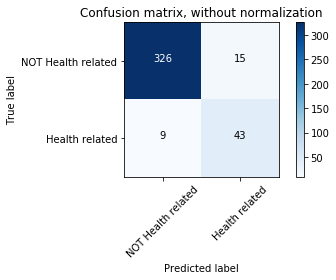

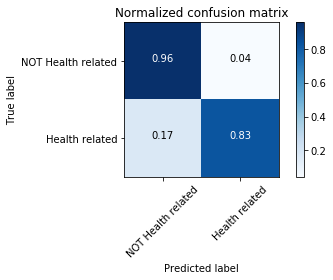



=========== PREDICTION =============
Number of records: 393 [0, 0.0% filtered out]
prediction accuracy: 93.89% [vs. 14.76% if assumed all Health related ]
prediction recall: 82.69%
prediction precision: 74.14%
prediction f1: 78.18%




In [10]:
test = pickle.load(open("./data/test.pkl", "rb" ))

print("Predicting ...")
predict1 = predict_fasttext(test, text_field_pp, fasttext_model_name + ".ftz")

output_metrics(predict1[response_field],predict1['prediction'], len(test), response_field)


Not too bad. As mentioned, this is a quick demo, with more data and hyper-parameter tuning we could improve performance.


## Using a model trained on Bill categories in one state, predict categories on Bills in another state

Let's read bills data for South Dakota.

In [11]:
state = 'SD'
fl = './data/' + state + '_Bills_2.csv'

# Get the data files if we don't have them
if not os.path.isfile(fl):
    s3_link = "https://datakind-public.s3.amazonaws.com/NLP_data/Bills_V2.zip"
    print("Downloading " + s3_link)
    resp = requests.get(s3_link).content
    zipfile = ZipFile(BytesIO(resp))
    zipfile.extractall(ddir)

df2 = pd.read_csv(fl, index_col=0)
df2['state'] = fl.replace('./data/','').replace('_Bills_2.csv','')

print('{} bills total'.format(df2.shape[0]))
print('BY YEAR')
print(df2.groupby('year').count()['bill_id'])
print()

df2['word_count'] = df2['text'].apply(lambda x: len(str(x).split(" ")))

print("Done")


2713 bills total
BY YEAR
year
2009    273
2010    244
2011    224
2012    252
2013    260
2014    248
2015    257
2016    236
2017    219
2018    282
2019    218
Name: bill_id, dtype: int64

Done


### Predict

Using our model, let's predict which South Dakota bills are health-related.

In [12]:
# Restrict to the state we're interested in
test2       = df2[df2['state'] == state]

# Concatenate title and text
test2["model_text"] = test2['title'] + '\n\n\n' + test2['text']

print("Pre-processing text ...")
test2 = preprocessFastText(test2, text_field, lemmatize=False, removeStopWords=False)

# Make our prediction
predict1 = predict_fasttext(test2, text_field_pp, fasttext_model_name + ".ftz")

# Isolate cases where the model thought the bill was 'health and safety' related
health_related_bills = predict1.loc[predict1["prediction"]==1]

# Output excerpts of the Bill text
print("\n\nExample of bills predicted as being health-related:\n")
for t in health_related_bills["title"][0:10]:
    print("----------------------------------------------")
    print(t)

Pre-processing text ...
fastext_model-Healthrelated-0.2-100-550-3---.ftz


Example of bills predicted as being health-related:

----------------------------------------------
 An Act to  revise the definition of an accredited prevention or treatment facility for the purposes of the prevention and treatment of alcohol and drug abuse. 
----------------------------------------------
 An Act to  revise certain drug registration fees and license fees related to health care facilities. 
----------------------------------------------
 An Act to provide for the monitoring of the prescribing and dispensing of controlled substances. 
----------------------------------------------
 An Act to establish certain legislative findings pertaining to the decision of a pregnant mother considering termination of her relationship with her child by an abortion, to establish certain procedures to better insure that such decisions are voluntary, uncoerced, and informed, and to revise certain causes of action 




Those seem like health related Bills, the model was able to classify them reasonably well just using titles.

So, if we train a model to recognize health bills using data from one state, we can then use it to predict the same for Bills data in another state. Even if that state doesn't have health bills labelled.

Hope this has been helpful, good luck!


.
